# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [ ]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

# Get each sample's population origin

In [17]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/country_origin")
df = DataFrame(sample = String[], population = String[])
refID_to_population = Dict{String, String}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        push!(df, (sample, population))
        refID_to_population[sample] = population
    end
end
refID_to_population

Dict{String,String} with 2709 entries:
  "HG01791" => "GBR"
  "HG02736" => "PJL"
  "HG00182" => "FIN"
  "HG03914" => "BEB"
  "HG00149" => "GBR"
  "NA12156" => "CEU"
  "HG02642" => "GWD"
  "HG02851" => "GWD"
  "NA19835" => "ASW"
  "NA19019" => "LWK"
  "HG01131" => "CLM"
  "HG03725" => "ITU"
  "HG03578" => "MSL"
  "NA18550" => "CHB"
  "HG02401" => "CDX"
  "HG01350" => "CLM"
  "HG03973" => "ITU"
  "NA07000" => "CEU"
  "HG01709" => "IBS"
  "HG01395" => "PUR"
  "HG02388" => "CDX"
  "HG01980" => "PEL"
  "HG01979" => "PEL"
  "HG01122" => "CLM"
  "HG03869" => "ITU"
  ⋮         => ⋮

# Compute phase information

In [3]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.jlso"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=true, max_d=d,
    phase=true);

Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:08


Total windows = 2367, averaging ~ 527 unique haplotypes per window.

Timings: 
    Data import                     = 18.6085 seconds
        import target data             = 5.07678 seconds
        import compressed haplotypes   = 13.5317 seconds
    Computing haplotype pair        = 8.31547 seconds
        BLAS3 mul! to get M and N      = 0.322331 seconds per thread
        haplopair search               = 3.80709 seconds per thread
        initializing missing           = 0.0235531 seconds per thread
        allocating and viewing         = 0.0741739 seconds per thread
        index conversion               = 0.00159498 seconds per thread
    Phasing by win-win intersection = 0.713895 seconds
        Window-by-window intersection  = 0.097459 seconds per thread
        Breakpoint search              = 0.0918127 seconds per thread
        Recording result               = 0.0126162 seconds per thread
    Imputation                     = 3.42463 seconds
        Imputing missing          

In [4]:
# check ultra-compression matches vcf.gz compression
X_answer = convert_gt(UInt8, "mendel.imputed.vcf.gz", trans=true)
X1, X2, _, _, H = convert_compressed(UInt8, outfile, "ref.chr18.excludeTarget.vcf.gz")
X_phased = X1 + X2
all(X_answer .== X_phased)

importing reference data...100%|████████████████████████| Time: 0:03:50


true

# Compute sample composition in 1000 genomes

In [16]:
# need compressed reference panel
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]
panelID = compressed_Hunique.sampleID

# get sample's ancestry
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [sample_to_population[id] for id in tgtID];

In [14]:
findall(x -> x == "CHS", sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.000620 seconds (8 allocations: 1.250 KiB)
  0.000443 seconds (8 allocations: 1.250 KiB)
  0.000530 seconds (8 allocations: 1.250 KiB)


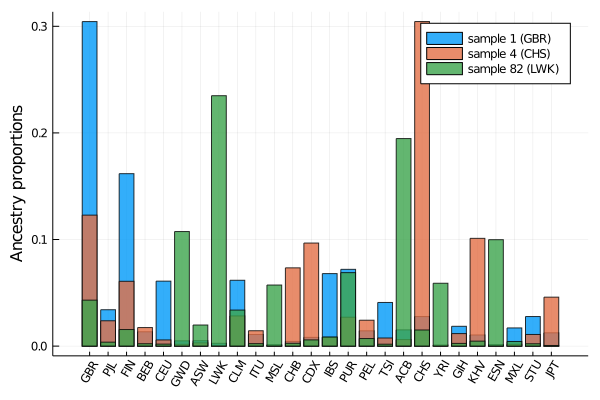

In [27]:
populations = unique_populations(refID_to_population)
@time sample1_comp = paint(ph[1], panelID, refID_to_population)
@time sample4_comp = paint(ph[4], panelID, refID_to_population)
@time sample82_comp = paint(ph[82], panelID, refID_to_population)

barplot = bar(sample1_comp, xticks=(1:1:26, populations), xrotation=60, 
    ylabel = "Ancestry proportions", label="sample 1 (GBR)", alpha=0.8)
bar!(barplot, sample4_comp, label="sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample82_comp, label="sample 82 (LWK)", alpha=0.8)

In [26]:
savefig(barplot, "admixture.png") # remember to set dpi=300